# Data preprocessing

In [1]:
!pip install pywavelets tensorflow matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pywt
import torch

2025-06-09 05:21:04.994133: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 05:21:05.012338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749446465.032382   32877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749446465.038630   32877 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749446465.058371   32877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
def load_audio_files_cwt(directory, num_classes=6):
    files = os.listdir(directory)
    audios = []
    labels = []

    target_duration = 0.05  # 50ms
    sr = 22050
    target_freq_bins = 128
    target_time_steps = 1024

    for file in files:
        if file.endswith('.wav'):
            path = os.path.join(directory, file)

            # 다중 라벨 처리: [0, 1, 0, 0, 0, 0] 형식으로 변환
            label_index = int(file[:4])  # 예: 파일 이름의 앞 4자리

            # 오디오 로드
            audio, _ = librosa.load(path, sr=sr)

            # 길이 맞추기 (50ms 고정)
            target_length = int(target_duration * sr)
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            else:
                onset_frames = librosa.onset.onset_detect(y=audio, sr=sr, units="samples")
                onset_sample = onset_frames[0] if len(onset_frames) > 0 else 0
                end_sample = onset_sample + target_length
                audio = audio[onset_sample:end_sample]
                if len(audio) < target_length:
                    audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

            # Hamming 윈도우 적용
            audio *= np.hamming(len(audio))

            # CWT 변환 (1, freq_bins, time_steps)
            scales = np.arange(1, target_freq_bins + 1)
            cwt_matrix, _ = pywt.cwt(audio, scales, 'morl')
            cwt_magnitude = np.abs(cwt_matrix)  # (128, time)

            # 시간 축 조정 (pad or crop to 1024)
            time_len = cwt_magnitude.shape[1]
            if time_len < target_time_steps:
                pad_width = target_time_steps - time_len
                cwt_magnitude = np.pad(cwt_magnitude, ((0, 0), (0, pad_width)), mode='constant')
            else:
                cwt_magnitude = cwt_magnitude[:, :target_time_steps]

            # (1, 128, 1024)로 reshape
            cwt_tensor = torch.tensor(cwt_magnitude).unsqueeze(0).float()
            audios.append(cwt_tensor.numpy())
            labels.append(label_index)

    return audios, labels

In [7]:
audios, labels = load_audio_files_cwt('sliced')

print(audios[0].shape) # (1, 128, 1024)
print(len(audios))

/opt/conda/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(


(1, 128, 1024)
38572


In [8]:
# 라벨과 원-핫 인코딩 벡터 매핑 딕셔너리
label_to_multihot = {
    0: [0,0,0,0,0,0],
    1: [1,0,0,0,0,0],
    2: [0,1,0,0,0,0],
    6: [0,0,0,1,0,0],
    8: [0,0,0,0,1,0],
    11: [0,0,0,0,0,1],
    12: [0,0,1,0,0,0],
    106: [1,0,0,1,0,0],
    108: [1,0,0,0,1,0],
    111: [1,0,0,0,0,1],
    206: [0,1,0,1,0,0],
    208: [0,1,0,0,1,0],
    211: [0,1,0,0,0,1],
    608: [0,0,0,1,1,0],
    611: [0,0,0,1,0,1],
    612: [0,0,1,1,0,0],
    811: [0,0,0,0,1,1],
    812: [0,0,1,0,1,0],
    1112: [0,0,1,0,0,1],
}

# 원-핫 인코딩 변환 함수
def convert_to_multihot(labels, label_to_onehot):
    multihot_encoded = np.array([label_to_multihot[label] for label in labels])
    return multihot_encoded

# 라벨 변환
labels_multihot = convert_to_multihot(labels, label_to_multihot)
print(labels_multihot)

[[1 0 0 1 0 0]
 [1 0 0 0 0 1]
 [0 0 1 1 0 0]
 ...
 [0 1 0 0 0 1]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]


In [9]:
import numpy as np
from collections import defaultdict

# 다중 라벨 데이터를 균형 있게 샘플링하는 함수
def balanced_sampling(X, y, sample_size=50, random_state=42):
    np.random.seed(random_state)
    
    # 라벨을 문자열로 변환하여 그룹화 (mutable 자료형인 리스트는 직접 비교 불가하기 때문)
    label_dict = defaultdict(list)
    
    for idx, label in enumerate(y):
        label_str = str(label.tolist())  # 리스트를 문자열로 변환하여 key로 사용
        label_dict[label_str].append(idx)
    
    train_indices = []
    test_indices = []
    
    for label_str, indices in label_dict.items():
        np.random.shuffle(indices)  # 랜덤하게 섞기
        
        test_sample = indices[:50]  # 테스트 세트: 50개 고정
        train_sample = indices[50:]  # 나머지는 훈련 세트
        
        test_indices.extend(test_sample)
        train_indices.extend(train_sample)
        
        print(f"Label: {label_str}, Train: {len(train_sample)}, Test: {len(test_sample)}")
    
    # 최종 선택된 데이터 추출
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

X = np.array(audios)  # 리스트 -> NumPy 배열 변환
y = np.array(labels_multihot)  # 리스트 -> NumPy 배열 변환

# 데이터셋 분할 실행
X_train, X_test, y_train, y_test = balanced_sampling(X, y)

Label: [1, 0, 0, 1, 0, 0], Train: 1950, Test: 50
Label: [1, 0, 0, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 1, 1, 0, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 1, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 1, 0, 0, 0], Train: 2287, Test: 50
Label: [1, 0, 0, 0, 0, 0], Train: 1950, Test: 50
Label: [0, 1, 0, 1, 0, 0], Train: 1950, Test: 50
Label: [0, 1, 0, 0, 0, 0], Train: 1950, Test: 50
Label: [0, 1, 0, 0, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 0, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 1, 1], Train: 1950, Test: 50
Label: [1, 0, 0, 0, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 1, 0, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 1, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 0, 1, 0, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 1, 0, 1], Train: 1950, Test: 50
Label: [0, 1, 0, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 1, 0], Train: 2185, Test: 50


# training

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import timm

cuda


In [11]:
class ViTForCWTMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(ViTForCWTMultiLabel, self).__init__()

        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=True,
            img_size=(128, 1024),   # CWT 해상도
            in_chans=3,             # 1채널 → 3채널 repeat
            num_classes=num_classes
        )

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # (B, 1, H, W) → (B, 3, H, W)
        return self.vit(x)  # logits 반환 (sigmoid는 inference 시 따로 적용)

In [12]:
# 커스텀 데이터셋 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, audios, labels, max_time_dim=None, transform=None):
        self.audios = audios
        self.labels = labels
        self.max_time_dim = max_time_dim or max([audio.shape[-1] for audio in audios])  # 최대 시간 축 크기 찾기
        self.transform = transform

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        sample = self.audios[idx]  # NumPy 배열로 된 오디오 데이터를 로드
        label = self.labels[idx]

        # NumPy 배열을 텐서로 변환
        sample = torch.tensor(sample).float()  # [1, 1026, N] 형식

        # 시간 축을 기준으로 패딩 적용하여 최대 시간 길이에 맞춤
        time_padding = self.max_time_dim - sample.shape[-1]
        if time_padding > 0:
            sample = torch.nn.functional.pad(sample, (0, time_padding), mode='constant', value=0)

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# 데이터 증강 및 전처리 변환 설정 (이미 텐서로 변환되었으므로 ToTensor()는 불필요)
train_transform = None
test_transform = None

# PyTorch Dataset 생성
train_dataset = AudioDataset(X_train, y_train, transform=train_transform)
test_dataset = AudioDataset(X_test, y_test, transform=test_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample, label = train_dataset[0]
sample_size = sample.size()
sample_size

torch.Size([1, 128, 1024])

In [13]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import os
import matplotlib.pyplot as plt

# 모델, 옵티마이저, 학습 기록 저장 함수
def save_checkpoint(epoch, model, optimizer, history, best_val_accuracy, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'best_val_accuracy': best_val_accuracy
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# 저장된 체크포인트 불러오기
def load_checkpoint(filename, model, optimizer):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        best_val_accuracy = checkpoint['best_val_accuracy']
        print(f"Checkpoint loaded from epoch {epoch+1}")
        return epoch, history, best_val_accuracy
    else:
        print("No checkpoint found.")
        return 0, {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}, 0.0

# 학습 기록 그래프 출력 함수
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
def evaluate(model, loader, classification_criterion):
    model.eval()
    running_loss = 0.0
    correct_per_sample = 0  
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            class_output_logits = model(inputs)
            classification_loss = classification_criterion(class_output_logits, labels)
            running_loss += classification_loss.item()

            # Sigmoid 적용 후 이진화
            class_output = torch.sigmoid(class_output_logits)
            preds = (class_output > 0.5).int()

            # 샘플 단위 정확도
            correct_per_sample += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.shape[0]  

    accuracy = correct_per_sample / total_samples
    return running_loss / len(loader), accuracy

In [15]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, scheduler, checkpoint_file='checkpoint.pth'):
    start_epoch, history, best_val_accuracy = load_checkpoint(checkpoint_file, model, optimizer)
    best_model_wts = copy.deepcopy(model.state_dict())

    classification_criterion = nn.BCEWithLogitsLoss()

    patience = 10
    early_stop_counter = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"Epoch [{epoch+1}/{num_epochs}] training...")


        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            class_output_logits = model(inputs)
            classification_loss = classification_criterion(class_output_logits, labels)

            loss = classification_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(class_output_logits) > 0.5).int()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.shape[0]

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        print("Evaluating on validation set...")
        val_loss, val_accuracy = evaluate(model, test_loader, classification_criterion)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, "
              f"Val_Loss: {val_loss:.4f}, Val_Acc: {val_accuracy:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0  
            print(f"🔥 New best model with val_accuracy: {val_accuracy:.4f} 🔥")
        else:
            early_stop_counter += 1
            print(f"🛑 No improvement. EarlyStop counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("❗ Early stopping triggered.")
                break

        save_checkpoint(epoch, model, optimizer, history, best_val_accuracy, checkpoint_file)

        # best 모델 저장
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), 'best_model.pth')

        # scheduler.step()
        scheduler.step() 
        print(f"Updated Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    return model, history


In [20]:
from torch.optim.lr_scheduler import StepLR

# 학습 실행
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = ViTForCWTMultiLabel(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 스케줄러 추가
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

filename = "checkpoint_0424_ViT/checkpoint.pth"

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, scheduler, filename)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

No checkpoint found.
Epoch [1/20] training...


Evaluating on validation set...
Epoch [1/20], Loss: 0.3140, Acc: 0.4414, Val_Loss: 0.2565, Val_Acc: 0.5589
🔥 New best model with val_accuracy: 0.5589 🔥
Checkpoint saved at epoch 1
Updated Learning Rate: 0.000100
Epoch [2/20] training...


Evaluating on validation set...
Epoch [2/20], Loss: 0.2325, Acc: 0.5992, Val_Loss: 0.2291, Val_Acc: 0.6095
🔥 New best model with val_accuracy: 0.6095 🔥
Checkpoint saved at epoch 2
Updated Learning Rate: 0.000100
Epoch [3/20] training...


Evaluating on validation set...
Epoch [3/20], Loss: 0.2049, Acc: 0.6503, Val_Loss: 0.2050, Val_Acc: 0.6568
🔥 New best model with val_accuracy: 0.6568 🔥
Checkpoint saved at epoch 3
Updated Learning Rate: 0.000100
Epoch [4/20] training...


Evaluating on validation set...
Epoch [4/20], Loss: 0.1844, Acc: 0.6874, Val_Loss: 0.2219, Val_Acc: 0.6179
Checkpoint saved at epoch 4
Updated Learning Rate: 0.000100
Epoch [5/20] training...


Evaluating on validation set...
Epoch [5/20], Loss: 0.1849, Acc: 0.6866, Val_Loss: 0.1822, Val_Acc: 0.6863
🔥 New best model with val_accuracy: 0.6863 🔥
Checkpoint saved at epoch 5
Updated Learning Rate: 0.000090
Epoch [6/20] training...


Evaluating on validation set...
Epoch [6/20], Loss: 0.1632, Acc: 0.7265, Val_Loss: 0.1737, Val_Acc: 0.7221
🔥 New best model with val_accuracy: 0.7221 🔥
Checkpoint saved at epoch 6
Updated Learning Rate: 0.000090
Epoch [7/20] training...


Evaluating on validation set...
Epoch [7/20], Loss: 0.1476, Acc: 0.7542, Val_Loss: 0.1825, Val_Acc: 0.7200
Checkpoint saved at epoch 7
Updated Learning Rate: 0.000090
Epoch [8/20] training...


Evaluating on validation set...
Epoch [8/20], Loss: 0.1457, Acc: 0.7568, Val_Loss: 0.1748, Val_Acc: 0.7189
Checkpoint saved at epoch 8
Updated Learning Rate: 0.000090
Epoch [9/20] training...


Evaluating on validation set...
Epoch [9/20], Loss: 0.1455, Acc: 0.7564, Val_Loss: 0.1644, Val_Acc: 0.7168
Checkpoint saved at epoch 9
Updated Learning Rate: 0.000090
Epoch [10/20] training...


Evaluating on validation set...
Epoch [10/20], Loss: 0.1463, Acc: 0.7571, Val_Loss: 0.1867, Val_Acc: 0.6895
Checkpoint saved at epoch 10
Updated Learning Rate: 0.000081
Epoch [11/20] training...


Evaluating on validation set...
Epoch [11/20], Loss: 0.1406, Acc: 0.7672, Val_Loss: 0.1694, Val_Acc: 0.7284
🔥 New best model with val_accuracy: 0.7284 🔥
Checkpoint saved at epoch 11
Updated Learning Rate: 0.000081
Epoch [12/20] training...


Evaluating on validation set...
Epoch [12/20], Loss: 0.1284, Acc: 0.7862, Val_Loss: 0.1840, Val_Acc: 0.7242
Checkpoint saved at epoch 12
Updated Learning Rate: 0.000081
Epoch [13/20] training...


Evaluating on validation set...
Epoch [13/20], Loss: 0.1254, Acc: 0.7919, Val_Loss: 0.1731, Val_Acc: 0.7379
🔥 New best model with val_accuracy: 0.7379 🔥
Checkpoint saved at epoch 13
Updated Learning Rate: 0.000081
Epoch [14/20] training...


Evaluating on validation set...
Epoch [14/20], Loss: 0.1160, Acc: 0.8068, Val_Loss: 0.1920, Val_Acc: 0.7137
Checkpoint saved at epoch 14
Updated Learning Rate: 0.000081
Epoch [15/20] training...


Evaluating on validation set...
Epoch [15/20], Loss: 0.1151, Acc: 0.8142, Val_Loss: 0.1763, Val_Acc: 0.7411
🔥 New best model with val_accuracy: 0.7411 🔥
Checkpoint saved at epoch 15
Updated Learning Rate: 0.000073
Epoch [16/20] training...


Evaluating on validation set...
Epoch [16/20], Loss: 0.0982, Acc: 0.8412, Val_Loss: 0.1820, Val_Acc: 0.7442
🔥 New best model with val_accuracy: 0.7442 🔥
Checkpoint saved at epoch 16
Updated Learning Rate: 0.000073
Epoch [17/20] training...


Evaluating on validation set...
Epoch [17/20], Loss: 0.0877, Acc: 0.8584, Val_Loss: 0.2053, Val_Acc: 0.7505
🔥 New best model with val_accuracy: 0.7505 🔥
Checkpoint saved at epoch 17
Updated Learning Rate: 0.000073
Epoch [18/20] training...


Evaluating on validation set...
Epoch [18/20], Loss: 0.0788, Acc: 0.8744, Val_Loss: 0.2140, Val_Acc: 0.7653
🔥 New best model with val_accuracy: 0.7653 🔥
Checkpoint saved at epoch 18
Updated Learning Rate: 0.000073
Epoch [19/20] training...


Evaluating on validation set...
Epoch [19/20], Loss: 0.0718, Acc: 0.8877, Val_Loss: 0.1921, Val_Acc: 0.7568
Checkpoint saved at epoch 19
Updated Learning Rate: 0.000073
Epoch [20/20] training...


Evaluating on validation set...
Epoch [20/20], Loss: 0.0705, Acc: 0.8884, Val_Loss: 0.2103, Val_Acc: 0.7821
🔥 New best model with val_accuracy: 0.7821 🔥
Checkpoint saved at epoch 20
Updated Learning Rate: 0.000066


# result - best val_accuracy: 0.7232

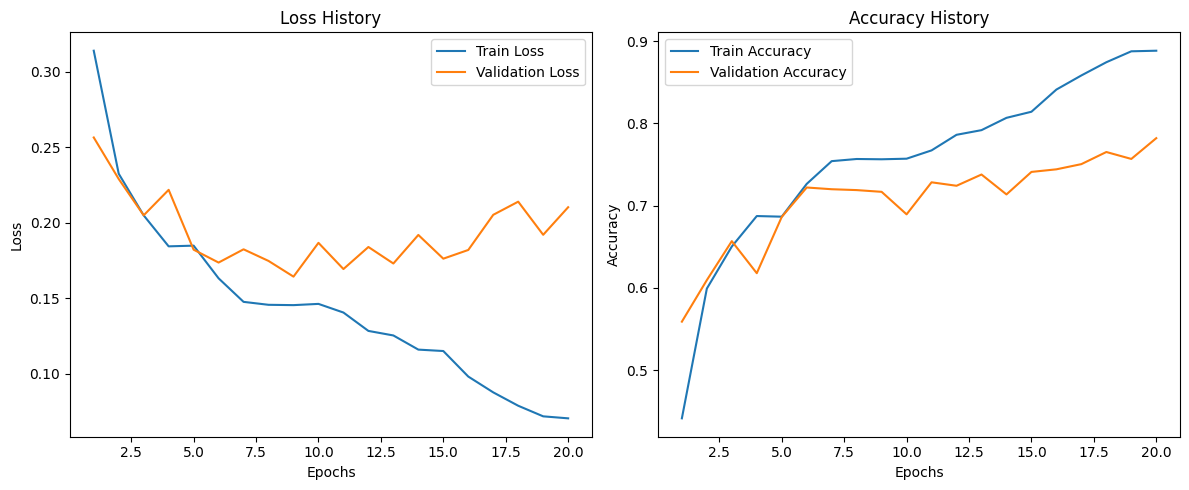

In [22]:
plot_history(history)